In [265]:
from closestRecipe import ClosestRecipe
import sqlite3
import pandas as pd
import folium 
import ipywidgets as widgets
from ipywidgets import interact
import seaborn as sns
import matplotlib.pyplot as plt

In [178]:
#  our closest recipe rank object for running queries
cr = ClosestRecipe()

In [179]:
# a little preview on the recipe rank for my zip
recipe_rank = cr.recipe_rank_zip('30082')
recipe_rank

,avg_dist,recipe,uid_recipe_title
0,1.906704,Green Bean Salad with Radishes and Prosciutto,63
1,1.906704,Ambrosia,72
2,1.906704,"Spinach Salad with Bosc Pears, Cranberries, Re...",81
3,1.906704,Pope,103
4,1.906704,Orange Gin Fizz,209
...,...,...,...
13909,728.195304,"Crispy Brown Rice ""Kabbouleh""",15315
13910,728.195304,Potato and Kale Cakes with Rouille,15628
13911,728.195304,Beans with Kale and Portuguese Sausage,16028
13912,728.195304,"Smoked Sausage, Kale and Potato Soup",16536


In [180]:
closest_ingredients = cr.recipe_rank_ings_zip('30082')
closest_ingredients

,uid_lat_long,distance,uid_recipe_ings,lat,long,recipe_ingredients,uid_recipe_title
0,796,5,265,33.939940,-84.574166,créme de cacao,4
1,796,5,265,33.939940,-84.574166,créme de cacao,1304
2,796,5,265,33.939940,-84.574166,créme de cacao,1342
3,796,5,265,33.939940,-84.574166,créme de cacao,1480
4,796,5,265,33.939940,-84.574166,créme de cacao,1949
...,...,...,...,...,...,...,...
67410,5698,47,91,34.263677,-85.213730,whole wheat,16278
67411,5698,47,91,34.263677,-85.213730,whole wheat,16280
67412,5698,47,91,34.263677,-85.213730,whole wheat,16624
67413,5698,47,91,34.263677,-85.213730,whole wheat,16777


In [181]:
rank_recipe_and_ingredients = pd.merge(recipe_rank, closest_ingredients, on='uid_recipe_title')
rank_recipe_and_ingredients

# tiny bit of cleanup
rank_recipe_and_ingredients['recipe'] = rank_recipe_and_ingredients['recipe'].str.strip()

# Let's Map It! 

In [278]:
def face_mapper(df, lat_long, recipe=None, singlemap=True, centroid=None, bounds=None):
    
#   preprocessing for making charts
    if recipe:
        df_ = df[df['recipe']==recipe]
    else:
        df_ = df
        pass
    user_lat_long = lat_long
    lats = df_['lat']
    longs = df_['long']
    popups = df_['recipe_ingredients']
    
    # constructing map
    # add user point
    if singlemap:
        m= folium.Map(
            location=user_lat_long
        )
        # single user marker
        folium.Marker(location=user_lat_long).add_to(m)
        m.fit_bounds([[lats.min(), longs.min()], [lats.max(), longs.max()]])
    else:
        m=folium.Map(
            location=centroid
        )
        m.fit_bounds(bounds)
    
    # should have investigated memoization and annotations more here
    from collections import defaultdict
    cache = defaultdict(lambda: defaultdict(list))
    def repeat_cache(s, _type, v):
        if _type == 'lines':
            cache[_type][s].append(1)
        if _type == 'markers':
            cache[_type][s].append(v)

    # makes the lines
    def make_poly_lines(s):
        p2 = (s['lat'], s['long'])
        if p2 not in cache['lines']:
            folium.PolyLine(
                locations=[user_lat_long, p2],
                weight=2
            ).add_to(m)
        repeat_cache(p2, 'lines', None)

    # makes the popup
    def make_popup_(s):
        popup = ',\n'.join([x for x in set(s)])
        return popup

    # makes the markers
    def make_markers(s):
        p = (s['lat'], s['long'])
        if p not in cache['markers']:
            popup= make_popup_(df_[df_['uid_lat_long']==s['uid_lat_long']]['recipe_ingredients'])
            folium.Marker(
                p, 
                popup=folium.Popup(popup, max_width=100, max_height=200)
            ).add_to(m)
        repeat_cache(p, 'markers', s['recipe_ingredients'])

    # loops through the dataframe (could use some enhancements)
    for s in df_.iterrows():
        make_poly_lines(s[1])
        make_markers(s[1])

    # return map for each zip
    return m

display(face_mapper(rank_recipe_and_ingredients, cr.lat_long))

In [275]:
def face_mapper(df, lat_long, m, recipe=None, singlemap=True, centroid=None, bounds=None):

    if recipe:
        df_ = df[df['recipe']==recipe]
    else:
        df_ = df

    user_lat_long = lat_long
    lats = df_['lat']
    longs = df_['long']
    popups = df_['recipe_ingredients']
    
    # should have investigated memoization and annotations more here
    from collections import defaultdict
    cache = defaultdict(lambda: defaultdict(list))
    def repeat_cache(s, _type, v):
        if _type == 'lines':
            cache[_type][s].append(1)
        if _type == 'markers':
            cache[_type][s].append(v)

    # makes the lines
    def make_poly_lines(s):
        p2 = (s['lat'], s['long'])
        if p2 not in cache['lines']:
            folium.PolyLine(
                locations=[user_lat_long, p2],
                weight=2
            ).add_to(m)
        repeat_cache(p2, 'lines', None)

    # makes the popup
    def make_popup_(s):
        popup = ',\n'.join([x for x in set(s)])
        return popup

    # makes the markers
    def make_markers(s):
        p = (s['lat'], s['long'])
        if p not in cache['markers']:
            popup= make_popup_(df_[df_['uid_lat_long']==s['uid_lat_long']]['recipe_ingredients'])
            folium.Marker(
                p, 
                popup=folium.Popup(popup, max_width=100, max_height=200)
            ).add_to(m)
        repeat_cache(p, 'markers', s['recipe_ingredients'])

    # loops through the dataframe (could use some enhancements)
    for s in df_.iterrows():
        make_poly_lines(s[1])
        make_markers(s[1])

    # return map for each zip
    return m


# Lets put it all together using functions for ease

In [276]:
zips = [30082,48109,80211]
def centroid_(coordinates):
    import math

    x = 0.0
    y = 0.0
    z = 0.0

    for coord in coordinates:
        latitude = math.radians(coord[0])
        longitude = math.radians(coord[1])

        x += math.cos(latitude) * math.cos(longitude)
        y += math.cos(latitude) * math.sin(longitude)
        z += math.sin(latitude)

    total = len(coordinates)

    x = x / total
    y = y / total
    z = z / total

    central_longitude = math.atan2(y, x)
    central_square_root = math.sqrt(x * x + y * y)
    central_latitude = math.atan2(z, central_square_root)

    return math.degrees(central_latitude),math.degrees(central_longitude)

def get_bounds(dfs):
    lat_mins = []
    lat_maxs = []
    long_mins = []
    long_maxs = []
    for df in dfs:
        lat_mins.append(df['lat'].min())
        lat_maxs.append(df['lat'].max())
        long_mins.append(df['long'].min())
        long_maxs.append(df['long'].max())
    return [(min(lat_mins), max(lat_maxs)), (min(long_mins), max(long_maxs))]

def get_map(centroid, bounds):
    m=folium.Map(
        location=centroid
    )
    m.fit_bounds(bounds)
    return m

def construct_df_for_vis(_zip):
    rr = cr.recipe_rank_zip(_zip)
    recipe_rank_ = rr
    ri = cr.recipe_rank_ings_zip(_zip)
    df = pd.merge(rr, ri, on='uid_recipe_title')
    return df, cr.lat_long

def make_df_by_zip(zip_):
    if type(zip_) == list:
        dfs = []
        ulat_longs = []
        for z in zip_:
            df, ulat_long = construct_df_for_vis(z)
            dfs.append(df)
            ulat_longs.append(ulat_long)
        centroid = centroid_(ulat_longs)
        return dfs, ulat_longs, centroid
    if type(zip_) == str:
        df, ulat_long = construct_df_for_vis(zip_)
        return df, ulat_long


zips = [30082,48109,80211]
dfs, ulat_longs, centroid = make_df_by_zip(zips)
bounds = get_bounds(dfs)
m = get_map(centroid, bounds)
for i,df in enumerate(dfs):
    face_mapper(df, ulat_longs[i], m)
m
    


In [277]:

# start of setting stuff
def user_dfs_latlong_from_construct(zip_):
    zips = None
    try:
        zips = zip_.split(',')
    except Exception as e:
        pass
    
    if zips:
        dfs, ulat_longs, centroid = make_df_by_zip(zips)
        # set global variable here
        return dfs, ulat_longs, centroid
    else: 
        df, ulat_long, centroid = make_df_by_zip(zip_)
        # set global variable here
        return df, ulat_long, centroid

zip_ = '48109'
recipe_ranked_ = cr.recipe_rank_zip('48109')

@interact(
    recipe=widgets.Dropdown(
        options = recipe_ranked_['recipe']
    ) 
)
def make_maps(recipe):
    dfs, ulat_longs, centroid = user_dfs_latlong_from_construct(zip_)
    bounds = get_bounds(dfs)
    m = get_map(centroid, bounds)
    for i,df in enumerate(dfs):
        face_mapper(df, ulat_longs[i], m, recipe=recipe)
    return display(m)
#     display(make_maps('Green Bean Salad with Radishes and Prosciutto '))


interactive(children=(Dropdown(description='recipe', options=('Pumpkin-Seed-Crusted Trout ', 'Cucumber, Tomato…

(42.2776, -83.7409)


ImportError: Cumulative distributions are currently only implemented in statsmodels. Please install statsmodels.

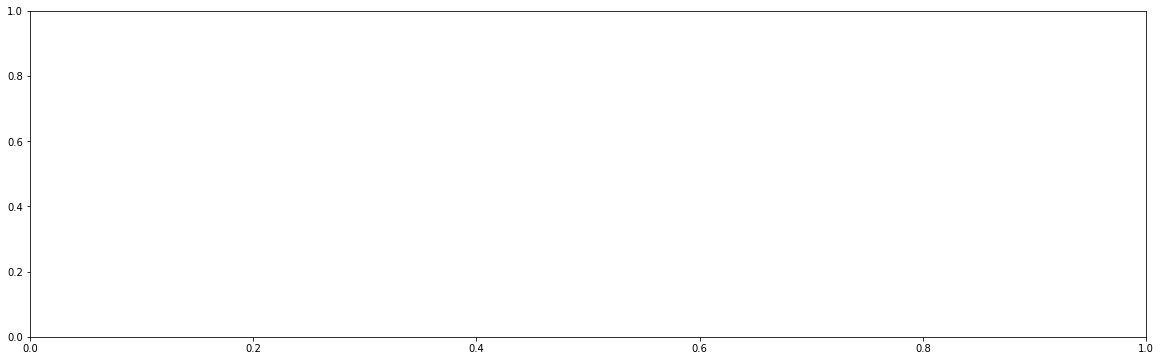

In [274]:
def dist_plot(x):
    plt.figure(figsize=(20, 6))
    mcdf = sns.kdeplot(x['avg_dist'], cumulative=True, shade=True, color="b").set(
        xlabel='recipe average distance', ylabel='% recipes closer')
    return mcdf

lat_long = cr.zip_lookup_lat_long(zip_)
print(lat_long)
display(dist_plot(cr.recipe_rank_zip(zip_)))

In [273]:
try:
    import statsmodels.nonparametric.api as smnp
    _has_statsmodels = True
except ImportError:
    _has_statsmodels = False

def dist_plot(x,y):
    #x = recipe_frame
    #y = current_index
    #density = (y+1)/len(x)
    plt.figure(figsize=(20, 6))
    mcdf = sns.kdeplot(x['avg_dist'], cumulative=True, shade=True, color="b").set(
        xlabel='recipe average distance', ylabel='% recipes closer')
    plt.plot([y, y], [0, 1])

display(dist_plot(cr.recipe_rank_zip(zip_)))

TypeError: dist_plot() missing 1 required positional argument: 'y'